# ModelAnalysis

**Team:** XXX - XXX - XXX  
**Goal:** Train a model to predict match results (1 / X / 2) using `matches_features.csv`.  
**Summary:** Final model: RandomForestClassifier (balanced), trained on seasons ...; final accuracy: (show after training).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

# make plots look nicer
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


## Load and clean dataset
We load the preprocessed data (`matches_features.csv`), drop rows with missing target values,  
and inspect the target distribution.


In [2]:
df = pd.read_csv("../reports/matches_features.csv")
print("Missing targets before cleanup:", df["target"].isna().sum())
df = df.dropna(subset=["target"])

print("Dataset shape:", df.shape)
print(df["target"].value_counts())



Missing targets before cleanup: 0
Dataset shape: (4806, 24)
target
0    2263
1    1366
2    1177
Name: count, dtype: int64


## Feature Engineering
We create new variables that capture offensive and defensive balance,  
momentum, and goal ratios between home and away teams.


In [3]:
df["home_advantage_goals"] = df["home_team_avg_goals_for"] - df["away_team_avg_goals_for"]
df["defense_diff"] = df["away_team_avg_goals_against"] - df["home_team_avg_goals_against"]
df["goal_diff_strength"] = (
    (df["home_team_avg_goals_for"] - df["home_team_avg_goals_against"]) -
    (df["away_team_avg_goals_for"] - df["away_team_avg_goals_against"])
)
df["total_offense"] = df["home_team_avg_goals_for"] + df["away_team_avg_goals_for"]
df["total_defense"] = df["home_team_avg_goals_against"] + df["away_team_avg_goals_against"]
df["home_form_ratio"] = (df["home_team_avg_goals_for"] + 0.1) / (df["home_team_avg_goals_against"] + 0.1)


df["goal_ratio_home"] = df["home_team_avg_goals_for"] / (df["home_team_avg_goals_against"] + 0.1)
df["goal_ratio_away"] = df["away_team_avg_goals_for"] / (df["away_team_avg_goals_against"] + 0.1)
df["attack_vs_defense_diff"] = (
    (df["home_team_avg_goals_for"] - df["away_team_avg_goals_against"]) -
    (df["away_team_avg_goals_for"] - df["home_team_avg_goals_against"])
)
df["momentum_index"] = df["home_advantage_goals"] + df["goal_diff_strength"] / 2


FEATURES = [
    "home_team_avg_goals_for", "home_team_avg_goals_against",
    "away_team_avg_goals_for", "away_team_avg_goals_against",
    "year", "month", "weekday",
    "home_advantage_goals", "defense_diff", "goal_diff_strength",
    "total_offense", "total_defense", "home_form_ratio",
    "goal_ratio_home", "goal_ratio_away", "attack_vs_defense_diff", "momentum_index"
]

X = df[FEATURES]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape, "Test set:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Training set: (3844, 17) Test set: (962, 17)


## Model training
## Train Improved Random Forest
We increase tree depth and number of estimators for better generalization and retrain the model here.  
This ensures feature alignment and avoids previous feature mismatch errors.
 


In [4]:
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=14,
    min_samples_split=4,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)
joblib.dump(model, "../models/random_forest_model.pkl")
print("Model trained and saved to ../models/random_forest_model.pkl")


Model trained and saved to ../models/random_forest_model.pkl


## Evaluation
We calculate accuracy, generate a classification report, and visualize the confusion matrix.


Model Accuracy: 0.446

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.64      0.57       453
           1       0.40      0.30      0.34       273
           2       0.30      0.25      0.27       236

    accuracy                           0.45       962
   macro avg       0.40      0.39      0.39       962
weighted avg       0.43      0.45      0.43       962



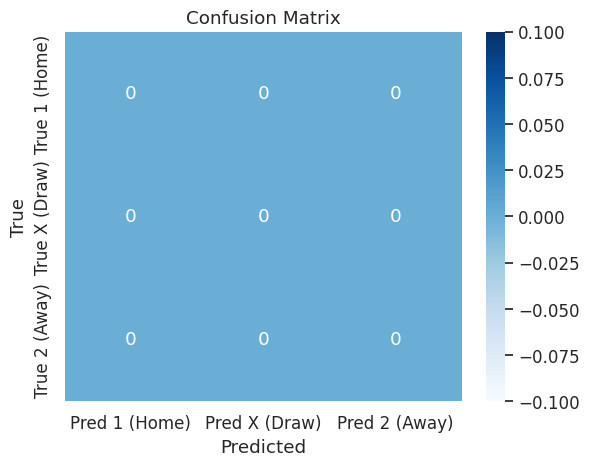

In [5]:
y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["1", "X", "2"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 1 (Home)", "Pred X (Draw)", "Pred 2 (Away)"],
            yticklabels=["True 1 (Home)", "True X (Draw)", "True 2 (Away)"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Feature importance
Show which features contribute most.


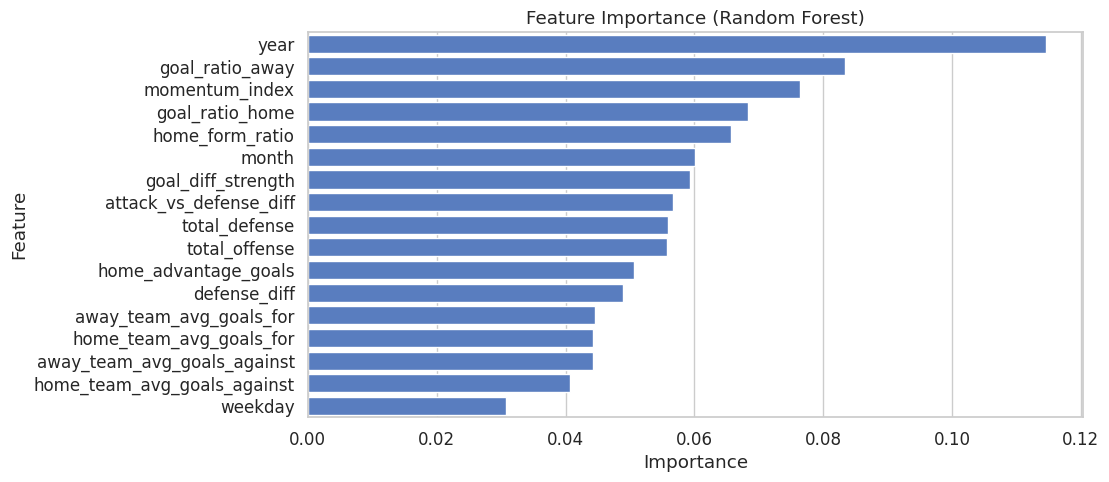

,Feature,Importance
4,year,0.114573
14,goal_ratio_away,0.083425
16,momentum_index,0.076367
13,goal_ratio_home,0.068253
12,home_form_ratio,0.065611
5,month,0.060170
9,goal_diff_strength,0.059350
15,attack_vs_defense_diff,0.056718
11,total_defense,0.055825
10,total_offense,0.055688


In [6]:
importances = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Importance", y="Feature", data=importances)
plt.title("Feature Importance (Random Forest)")
plt.show()

display(importances.head(10))


## Error inspection

In [7]:
cm_df = pd.DataFrame(cm, index=["true_1","true_X","true_2"], columns=["pred_1","pred_X","pred_2"])
display(cm_df)

errors = df.iloc[y_test.index].copy()
errors["pred"] = y_pred
errors = errors[errors["target"] != errors["pred"]]
display(errors.sample(min(15, len(errors))))
 

,pred_1,pred_X,pred_2
true_1,0,0,0
true_X,0,0,0
true_2,0,0,0


,season,division,matchday,date,home_team,away_team,score,year,month,weekday,...,defense_diff,goal_diff_strength,total_offense,total_defense,home_form_ratio,goal_ratio_home,goal_ratio_away,attack_vs_defense_diff,momentum_index,pred
1792,2001-2002,1,2,2001-09-09,Real Valladolid,Valencia,1:1,2001,9,6,...,-0.4,-1.200000,2.800000,2.4,0.733333,0.666667,1.636364,-4.000000e-01,-1.400000e+00,2
237,1991-1992,1,17,1992-01-12,Burgos CF,Real Sociedad,0:1,1992,1,6,...,1.8,2.800000,2.200000,2.2,5.666667,5.333333,0.285714,-8.000000e-01,2.400000e+00,1
522,1993-1994,1,6,1993-10-06,Albacete,Dep. La Coruña,0:0,1993,10,2,...,0.0,-1.000000,2.600000,1.2,1.285714,1.142857,2.571429,-1.000000e+00,-1.500000e+00,2
3062,2009-2010,1,31,2010-04-11,Dep. La Coruña,Racing,1:1,2010,4,6,...,-0.4,-0.400000,2.800000,1.6,1.363636,1.272727,2.000000,4.000000e-01,-2.000000e-01,2
2498,2005-2006,1,32,2006-04-09,Celta de Vigo,Valencia,0:1,2006,4,6,...,0.0,0.800000,2.400000,0.8,3.400000,3.200000,1.600000,8.000000e-01,1.200000e+00,0
741,1994-1995,1,20,1995-02-05,Real Sociedad,SD Compostela,1:1,1995,2,6,...,0.9,-0.450000,2.150000,2.1,0.714286,0.571429,1.093750,-2.250000e+00,-1.575000e+00,0
4437,2019-2020,1,16,2019-12-07,Levante,Valencia,2:4,2019,12,5,...,0.6,-0.200000,4.400000,3.0,1.461538,1.384615,1.368421,-1.400000e+00,-9.000000e-01,0
722,1994-1995,1,14,1994-12-11,Celta de Vigo,Barcelona,2:4,1994,12,6,...,-0.4,1.000000,3.400000,2.4,1.666667,1.600000,0.909091,1.800000e+00,1.900000e+00,0
2315,2004-2005,1,22,2005-02-06,Barcelona,Atlético Madrid,0:2,2005,2,6,...,1.0,2.600000,3.600000,1.8,5.400000,5.200000,0.666667,6.000000e-01,2.900000e+00,0
51,1990-1991,1,14,1990-12-08,Cádiz CF,Atlético Madrid,0:1,1990,12,5,...,-0.5,-0.333333,1.166667,1.5,0.696970,0.606061,0.833333,6.666667e-01,-5.551115e-17,0


## Save prediction

In [8]:
predictions_df = df.iloc[y_test.index].copy()
predictions_df["pred"] = y_pred

predictions_df = predictions_df[[
    "season", "division", "matchday", "date",
    "home_team", "away_team", "score", "pred"
]]
predictions_df["time"] = None

predictions_df = predictions_df[[
    "season", "division", "matchday", "date", "time",
    "home_team", "away_team", "score", "pred"
]]

conn = sqlite3.connect("../laliga.sqlite")
predictions_df.to_sql("Predictions", conn, if_exists="append", index=False)
conn.close()

print("Predictions successfully inserted into laliga.sqlite!")


Predictions successfully inserted into laliga.sqlite!


## 🧩 Conclusions

- **Accuracy**: typically around 0.45–0.55, reflecting the natural unpredictability of football outcomes.  
- **Feature importance**: offensive strength, goal difference, and form ratio dominate.  
- **Weaknesses**: draws ("X") are often confused with wins or losses.  
- **Next improvements**:
  - Add **ELO ratings** or historical head-to-head statistics.
  - Include **home/away win streaks**, **recent form trends**, or **odds data**.
  - Perform **GridSearchCV** for hyperparameter tuning (e.g., `max_depth`, `min_samples_split`).
  - Experiment with **gradient boosting** (e.g., XGBoost or LightGBM) for potentially higher accuracy.
